In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [13]:
import os
import sys
sys.path.insert(0, os.path.abspath('../bgflow'))
print(sys.path)
from bgflow.utils.types import assert_numpy


['/Users/johannes/git/projects/machine_learning_muca/bgflow', '/Users/johannes/git/projects/machine_learning_muca/bgflow', '/Users/johannes/git/projects/machine_learning_muca/bgflow', '/Users/johannes/git/projects/machine_learning_muca/notebooks', '/Users/johannes/.vscode/extensions/ms-toolsai.jupyter-2022.9.1303220346/pythonFiles', '/Users/johannes/.vscode/extensions/ms-toolsai.jupyter-2022.9.1303220346/pythonFiles/lib/python', '/Users/johannes/miniforge3/envs/bgflow/lib/python310.zip', '/Users/johannes/miniforge3/envs/bgflow/lib/python3.10', '/Users/johannes/miniforge3/envs/bgflow/lib/python3.10/lib-dynload', '', '/Users/johannes/miniforge3/envs/bgflow/lib/python3.10/site-packages', '/Users/johannes/miniforge3/envs/bgflow/lib/python3.10/site-packages/bgflow-0.3.0+16.g296f403-py3.10.egg']


In [14]:
# first define system dimensionality and a target energy/distribution

dim = 2

from bgflow import DoubleWellEnergy

target = DoubleWellEnergy(dim)

In [15]:
# define a MCMC sampler to sample from the target energy

from bgflow import GaussianMCMCSampler

init_state = torch.Tensor([[-2, 0], [2, 0]])
init_state = torch.cat([init_state, torch.Tensor(init_state.shape[0], dim-2).normal_()], dim=-1)
target_sampler = GaussianMCMCSampler(target, init_state=init_state)

In [16]:
# sample some data 

data = target_sampler.sample(5000)

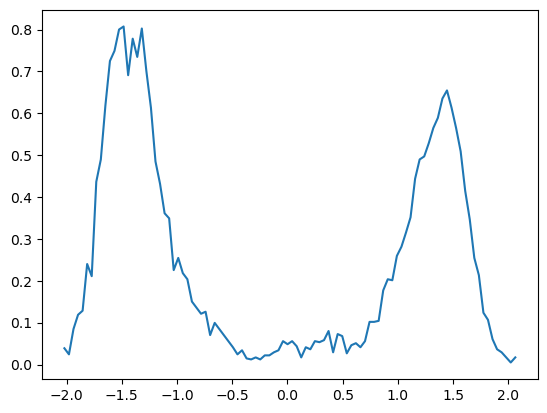

In [17]:
hist, bins = np.histogram(data[:,0], 100, density=True)
plt.plot(bins[:-1], hist)

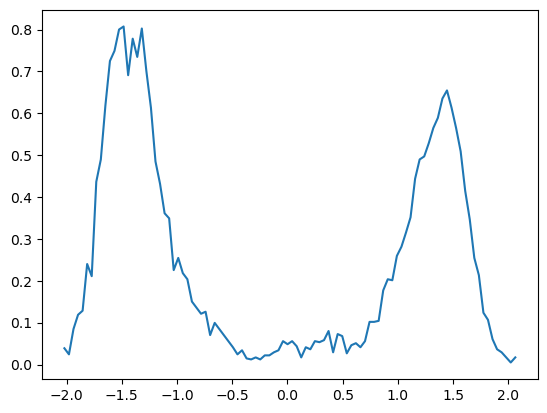

In [19]:
hist, bins = np.histogram(assert_numpy(data[:,0]), 100, density=True)
plt.plot(bins[:-1], hist)

In [21]:
def GMM_wrapper(x, N, *args):
    return GMM(x, args[0][:N], args[0][N:2*N], args[0][2*N:3*N])
    
def GMM(x, x0, sigma, pi):
    x0 = np.array(x0)
    sigma = np.array(sigma)
    pi = np.array(pi)
    assert(len(x0) == len(sigma))
    assert(len(sigma) == len(pi))
    pi /= np.sum(pi)
    #print("x0 equals {}" .format(x0))
    #print("x equals {}" . format(x))
    #print ( np.sum(pi/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x[:,np.newaxis]-x0)**2/(2*sigma**2))) )
    return np.sum(pi/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x[:,np.newaxis]-x0)**2/(2*sigma**2)),axis=1)

In [22]:
from scipy.optimize import curve_fit
N = 4
params_0 = np.ravel([np.random.choice(bins,size=N), np.ones(N), np.full(N,1/N)])
#print(params_0)
bounds = (np.ravel([np.full(N,-np.inf), np.full(N,-np.inf), np.zeros(N)]),
          np.ravel([np.full(N,+np.inf), np.full(N,+np.inf), np.ones(N)]))
#print(bounds)
print("bins is  {}" .format(bins[:-1]))
popt, pcov = curve_fit(lambda x, *p0: GMM_wrapper(x, N, p0), bins[:-1], hist, p0 = params_0, bounds = bounds)

bins is  [-2.0205112e+00 -1.9792603e+00 -1.9380095e+00 -1.8967586e+00
 -1.8555077e+00 -1.8142569e+00 -1.7730061e+00 -1.7317551e+00
 -1.6905043e+00 -1.6492535e+00 -1.6080027e+00 -1.5667518e+00
 -1.5255009e+00 -1.4842501e+00 -1.4429992e+00 -1.4017484e+00
 -1.3604975e+00 -1.3192466e+00 -1.2779958e+00 -1.2367450e+00
 -1.1954942e+00 -1.1542432e+00 -1.1129924e+00 -1.0717416e+00
 -1.0304908e+00 -9.8923987e-01 -9.4798905e-01 -9.0673816e-01
 -8.6548734e-01 -8.2423645e-01 -7.8298563e-01 -7.4173474e-01
 -7.0048392e-01 -6.5923303e-01 -6.1798221e-01 -5.7673138e-01
 -5.3548050e-01 -4.9422964e-01 -4.5297882e-01 -4.1172796e-01
 -3.7047711e-01 -3.2922626e-01 -2.8797540e-01 -2.4672455e-01
 -2.0547371e-01 -1.6422285e-01 -1.2297200e-01 -8.1721149e-02
 -4.0470295e-02  7.8055618e-04  4.2031407e-02  8.3282262e-02
  1.2453311e-01  1.6578396e-01  2.0703481e-01  2.4828567e-01
  2.8953651e-01  3.3078736e-01  3.7203822e-01  4.1328907e-01
  4.5453992e-01  4.9579078e-01  5.3704160e-01  5.7829249e-01
  6.1954331e-01

In [23]:
popt[2*N:3*N]

array([0.43103576, 0.15658952, 0.1020107 , 0.37444485])

In [24]:
values = GMM_wrapper(bins[:-1],N,popt)

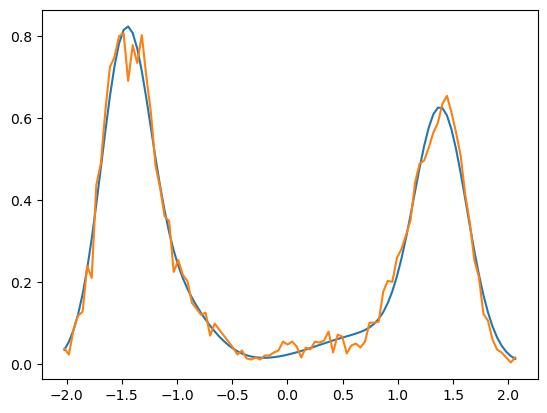

In [25]:
plt.plot(bins[:-1], values)
plt.plot(bins[:-1], hist)
plt.show()